# Visualize empirical correlation in HCP data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from readHCP import readHCP
from generateSyntheticData import generateCoordinates
from createBrainMask import createBrainMaskFromb0Data

%matplotlib inline

C:\Users\sesjojen\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Specify a folder containing preprocessed HCP data.

In [2]:
dataPath = 'C:\\Users\\sesjojen\\Documents\\Data\\HumanConnectomeProject\\mgh_1007\\diff\\preproc'
print(dataPath)

C:\Users\sesjojen\Documents\Data\HumanConnectomeProject\mgh_1007\diff\preproc


Read data from file.

In [3]:
gtab, data, voxelSize = readHCP(dataPath)
data.shape
print(gtab.info)

B-values shape (552,)
         min 0.000000 
         max 10050.000000 
B-vectors shape (552, 3)
         min -0.998755 
         max 0.998348 
None


Convert diffusion encoding to q-space features usable in prediction.

<function matplotlib.pyplot.show>

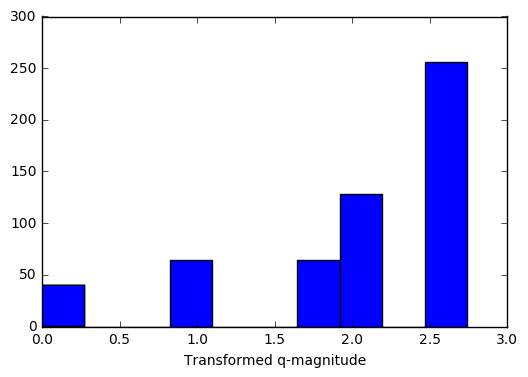

In [4]:
def qMagnitudeTransform(q):
    return np.log(1 + q ** 2) # The constant offset should probably be optimized (issue created)

qvecs = gtab.bvecs
qvals = gtab.qvals[:, np.newaxis]
qvalsTransformed = qMagnitudeTransform(qvals)

qFeatures = np.column_stack((qvalsTransformed, qvecs))

plt.hist(qvalsTransformed)
plt.xlabel('Transformed q-magnitude')
plt.show

Compute the spatial coordinates corresponding to each measurement (this function would be more appropriate somewhere other than in generateSyntheticData). The HCP data has voxel sizes (1.5, 1.5, 1.5) mm^3, but it would be more appropriate for the readHCP method to return this (issue created).

In [5]:
spatialDimensions = data.shape[0:3]
coordinates = generateCoordinates(spatialDimensions, voxelSize)
coordinates.shape

(1.5, 1.5, 1.5000001)


(1881600, 3)

Compute a mask containing the brain. For this we first need to create an average b0-img, which is done by averaging all b0 images. Then, we pass this to createBrainMaskFromb0Data() which uses Dipy's median_otsu() function.


In [6]:
allb0s = data[:, :, :, gtab.b0s_mask]
b0 = np.mean(allb0s, axis=3)

mask = createBrainMaskFromb0Data(b0)

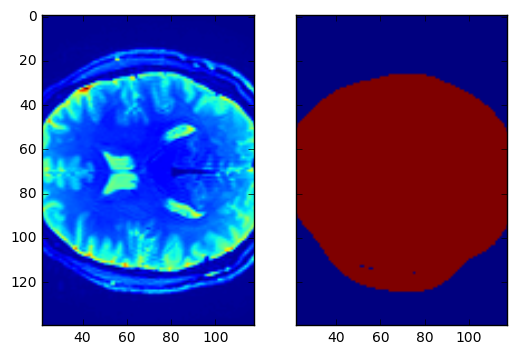

In [7]:
zSlice = 50
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(b0[:, :, zSlice])
ax2.imshow(mask[:, :, zSlice])


Get the (x, y, z)-indices of voxels belonging to the mask using numpy.nonzero().

In [8]:
maskIdx = np.nonzero(mask)
S = data[maskIdx[0], maskIdx[1], maskIdx[2], :]

Normalize by the b0-image, taking advantage of Numpy's broadcasting.

In [9]:
S = S/b0[maskIdx[0], maskIdx[1], maskIdx[2], np.newaxis]

Sort columns so that bvals are monotonically increasing: 0, 1000, 3000, 5000, 10000. Adjust other data accordingly.

In [10]:
bvalsIdxIncreasing = np.argsort(gtab.bvals)
bvals = gtab.bvals[bvalsIdxIncreasing]
S = S[:, bvalsIdxIncreasing]
qFeatures = qFeatures[bvalsIdxIncreasing, :]

In [11]:
scatterMatrix = np.dot(S.T, S)

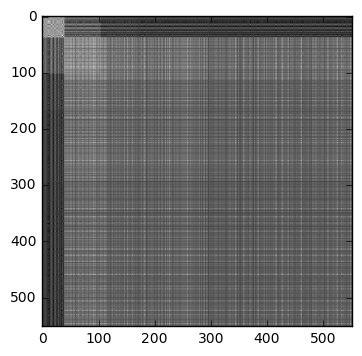

In [12]:
plt.imshow(scatterMatrix, cmap='gray')

In [13]:
negData = S[S<0]

In [14]:
np.median(b0[not maskIdx])

C:\Users\sesjojen\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


0.0